In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = './results'
model_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
model_names = [os.path.splitext(f)[0] for f in model_files]

corruption_list = sorted(list({
    row['corruption']
    for file in model_files
    for _, row in pd.read_csv(os.path.join(folder_path, file)).iterrows()
}))

corruption_to_idx = {name: idx for idx, name in enumerate(corruption_list)}

n_corruptions = len(corruption_list)
n_severities = 5
n_models = len(model_files)

# Initialisation du tableau (n_models, n_corruptions, n_severities)
all_data = np.zeros((n_models, n_corruptions, n_severities))

for i, file in enumerate(model_files):
    df = pd.read_csv(os.path.join(folder_path, file))
    for _, row in df.iterrows():
        c_idx = corruption_to_idx[row['corruption']]
        s_idx = int(row['severity']) - 1
        all_data[i, c_idx, s_idx] = row['f1_macro']


In [24]:
print("Ordre des modèles (model_names) :")
for i, name in enumerate(model_names):
    print(f"{i}: {name}")

Ordre des modèles (model_names) :
0: DenseNet_AdaGrad
1: DenseNet_Adam
2: DenseNet_SGD
3: ResNet_AdaGrad
4: ResNet_Adam
5: ResNet_SGD
6: VGGLike_AdaGrad
7: VGGLike_Adam
8: VGG_SGD


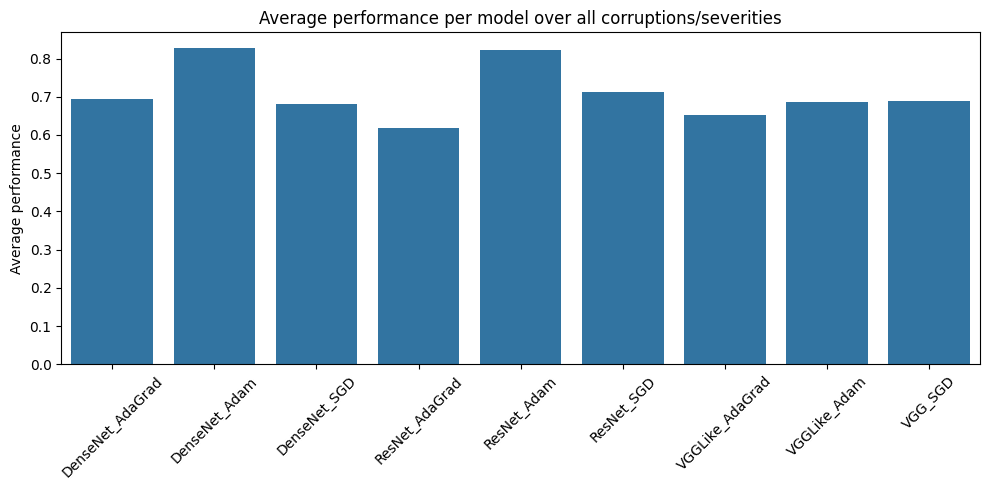

In [2]:
"""
Performances globales par modèle pour comparer la robustesse globale des modèles
    => permet de voir quel modèle est globalement le plus robuste

Axe X : Les 9 modèles
Axe Y : Moyenne des performances sur toutes les corruptions et sévérités
"""

model_means = all_data.mean(axis=(1, 2))  # mean over corruptions and severities

plt.figure(figsize=(10, 5))
sns.barplot(x=model_names, y=model_means)
plt.ylabel('Average performance')
plt.title('Average performance per model over all corruptions/severities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can see that Adam is more robust than others through all. 

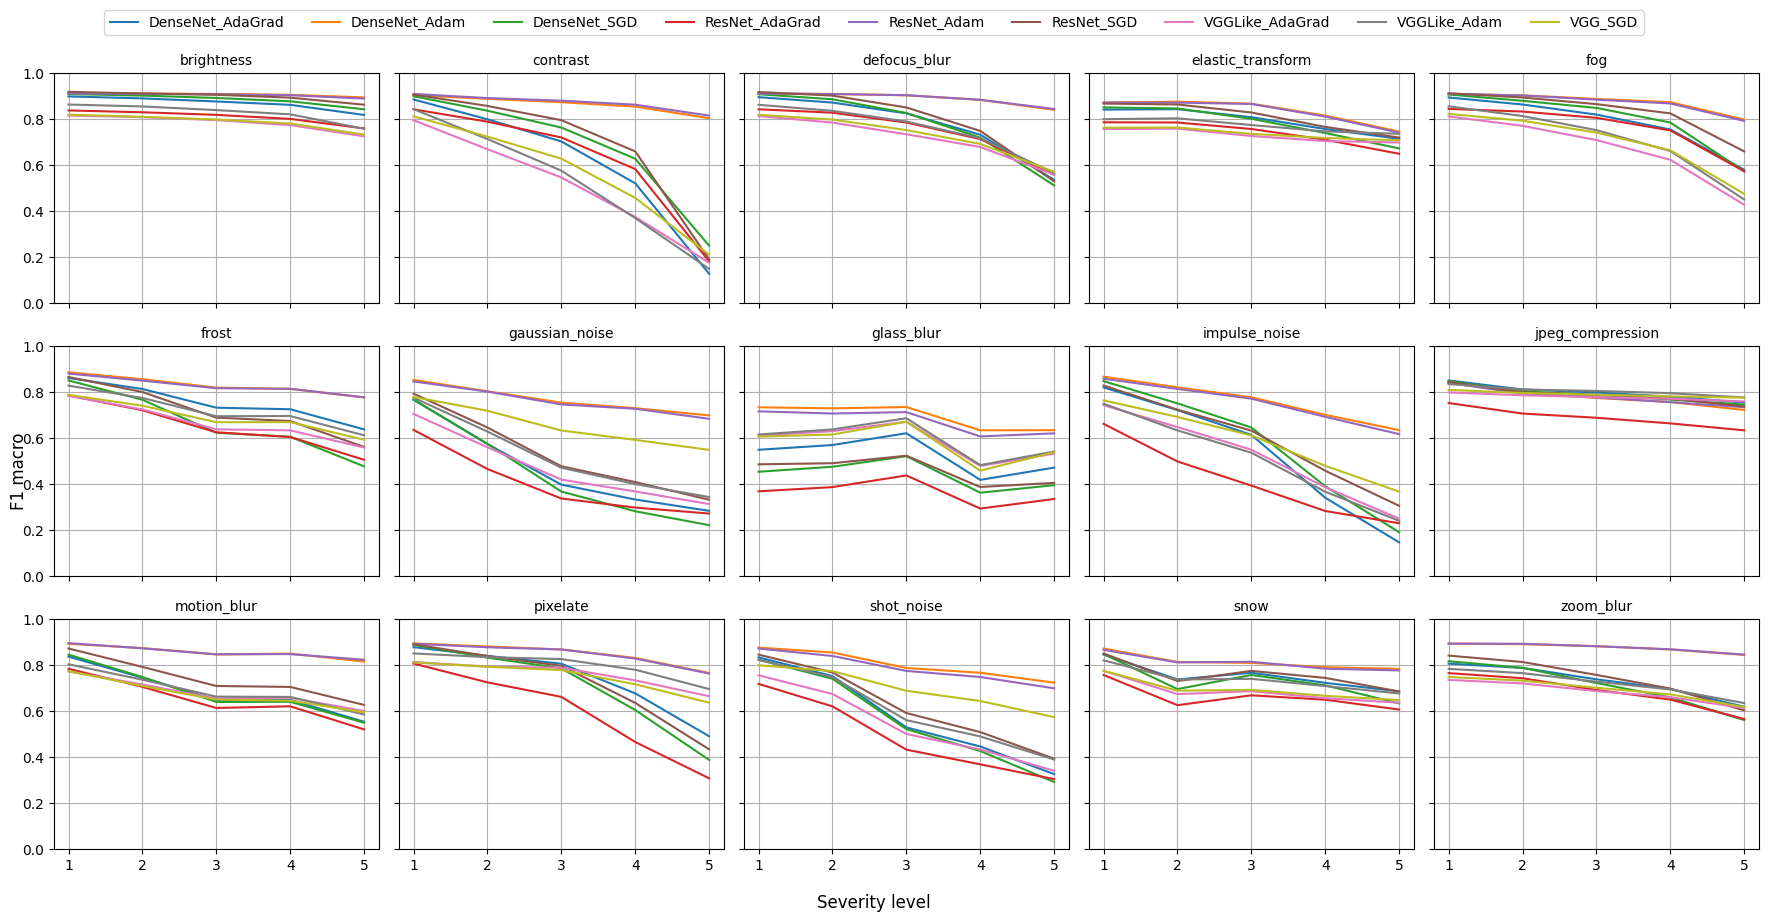

In [3]:
"""
Courbes de dégradation par corruption pour voir comment chaque modèle se dégrade avec la sévérité croissante d’une corruption donnée
    => montre quels modèles résistent le mieux à une corruption spécifique.

Axe X : Niveaux de sévérité (1 à 5)
Axe Y : Performance
"""


fig, axes = plt.subplots(3, 5, figsize=(18, 9), sharex=True, sharey=True)
axes = axes.flatten()

for c_idx, corruption in enumerate(corruption_list):
    ax = axes[c_idx]
    for m_idx, model_name in enumerate(model_names):
        ax.plot(
            range(1, 6),
            all_data[m_idx, c_idx],
            label=model_name,
            linewidth=1.5
        )
    ax.set_title(corruption, fontsize=10)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_ylim(0, 1)
    ax.grid(True)

fig.supxlabel('Severity level', fontsize=12)
fig.supylabel('F1 macro', fontsize=12)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=n_models, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

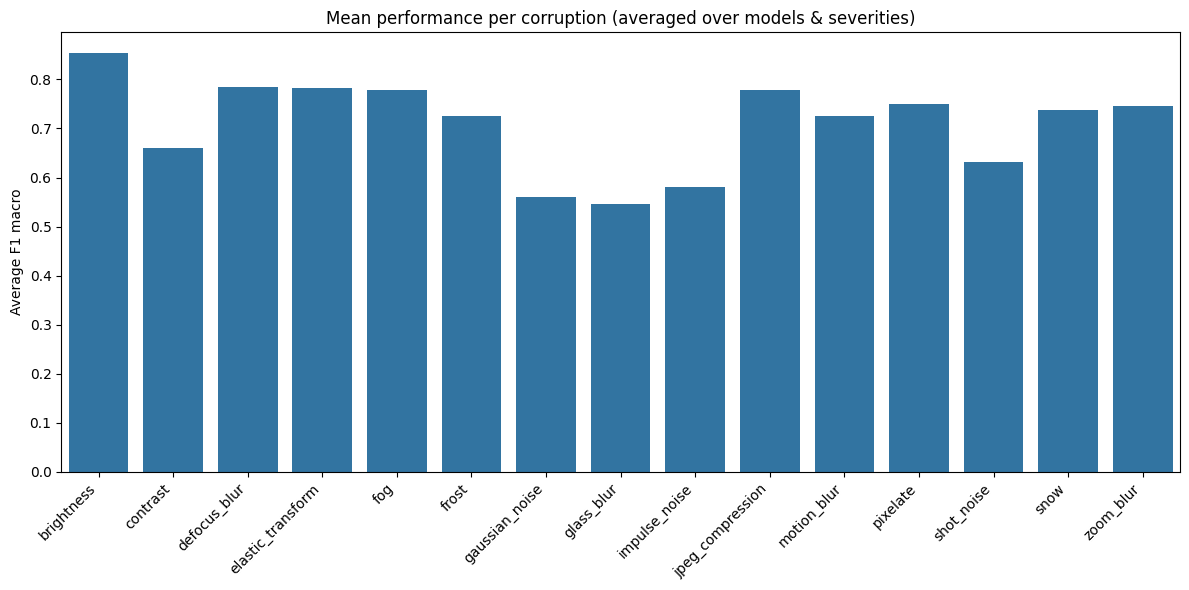

In [4]:
"""
Performance moyenne par corruption pour identifier les corruptions les plus dures en moyenne.

Axe X : Corruptions
Axe Y : Moyenne des scores sur tous les modèles et sévérités
"""
# Moyenne sur modèles et sévérités : shape (15,)
corruption_means = all_data.mean(axis=(0, 2))  

plt.figure(figsize=(12, 6))
sns.barplot(x=corruption_list, y=corruption_means)
plt.ylabel('Average F1 macro')
plt.title('Mean performance per corruption (averaged over models & severities)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


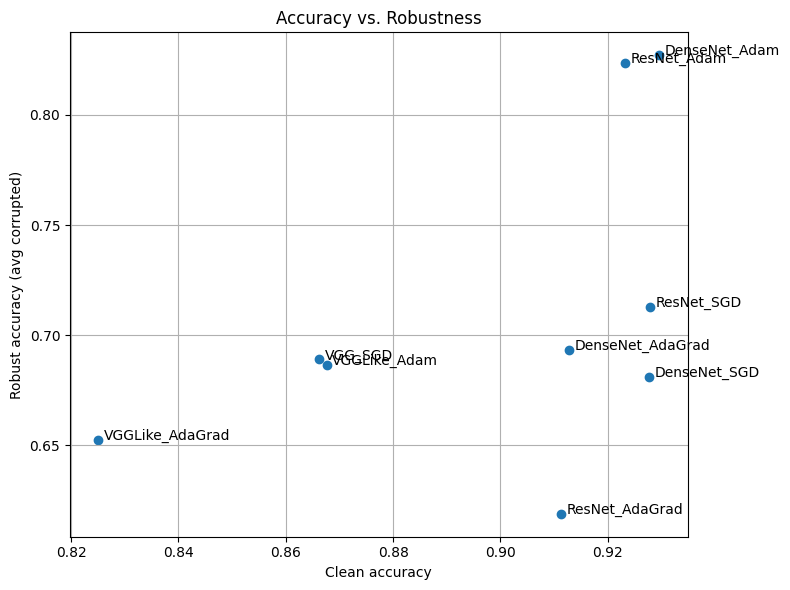

In [5]:
"""
Précision propre vs robustesse moyenne
    => visualise si certains modèles sacrifient la précision propre pour la robustesse, ou l’inverse

Axe X : Précision en conditions propres
Axe Y : Moyenne des performances corrompues
"""


clean_perfs = np.array([0.912782004, 0.929615, 0.9276285529110568, 0.9112470926, 0.923232, 0.9278731261953677, 0.8250410288, 0.867643, 0.8662728703153624])
robust_perfs = all_data.mean(axis=(1, 2))  # performance moyenne en condition corrompue

plt.figure(figsize=(8, 6))
plt.scatter(clean_perfs, robust_perfs)
for i, name in enumerate(model_names):
    plt.text(clean_perfs[i] + 0.001, robust_perfs[i], name)

plt.xlabel('Clean accuracy')
plt.ylabel('Robust accuracy (avg corrupted)')
plt.title('Accuracy vs. Robustness')
plt.grid(True)
plt.tight_layout()
plt.show()
